# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Select FRILL columns](#Select-FRILL-columns)
* [Throw out song samples](#Throw-out-song-samples)
* [Linear discriminant analysis of FRILL embeddings](#Linear-discriminant-analysis-of-FRILL-embeddings)
* [One-class SVM scores of the LDA components of the FRILL embeddings](One-class-SVM-scores-of-the-LDA-components-of-the-FRILL-embeddings)
* [SGDOneClassSVM scores of FRILL embeddings](#SGDOneClassSVM-scores-of-FRILL-embeddings-and-resultant-LDA-components)
* [Aggregate and scale](#Aggregate-and-scale)
* [Spot check](#Spot-check)
* [Discussion](#Discussion)

# Introduction

We are throwing out the song samples from training and re-running the simplified pipeline.

Despite such reductions, the Streamlit app was serving predictions very slowly. One of the bottlenecks was feature extraction, which has previously been unaccounted for when recording predict times, especially since most of the model development occured with pre-calculated splits and features within those splits.

The new pipeline seeks to further constrain feature processing. Loading the FRILL module alone turned out to be time consuming (though ameliorated with caching). We need the FRILL embeddings, but every additional step is another half second for a recruiter to get bored and swipe away to something else on their phone.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from copy import deepcopy
from gc import collect as gc_collect
from joblib import dump
from tqdm.notebook import tqdm

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# typing
from sklearn.base import BaseEstimator
from typing import Callable, List, Tuple

# feature engineering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import RidgeClassifierCV, SGDOneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
from sklearn.svm import OneClassSVM

# visualization
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %matplotlib widget
sns.set_theme(context="notebook", style="ticks", palette="colorblind")

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 4.16 s


# Data loading

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    keep_columns = [
        "id",
        "file",
        "source",
        "speaker_id",
        "speaker_gender",
        "emo",
        "valence",
        "neg",
        "neu",
        "pos",
        "lang1",
        "length",
    ]
    labels = pd.concat(
        (
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
            ),
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/nondev_labels.feather", columns=keep_columns
            ),
        )
    ).set_index("id")
    return labels


def load_data(filepath: str = "") -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Loads the FRILL data anew by default"""
    data = (
        pd.read_feather(f"{filepath}.feather")
        if filepath
        else pd.concat(
            (
                pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_FRILL.feather"),
                pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/nondev_FRILL.feather"),
            )
        )
    ).set_index("id")

    return data, load_labels().loc[data.index, :]


data, labels = load_data()
frill_columns = data.columns

assert all(data.index == labels.index)
_ = gc_collect()

time: 2.92 s


In [6]:
data.head(1)
data.info()
labels.head(1)
labels.info()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
id,,,,,,,,,,,,,,,,,,,,,
0,0.119926,-0.049218,0.039702,0.141101,0.044318,0.049631,0.016178,0.025797,-0.104466,-0.016044,...,-0.226529,-0.091773,0.028184,-0.074794,0.025474,0.046511,-0.002693,-0.017953,-0.146394,-0.06233


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 678.4 MB


,file,source,speaker_id,speaker_gender,emo,valence,neg,neu,pos,lang1,length
id,,,,,,,,,,,
0,00000+aesdd+aesdd.1+f+ang+-1+ell+el-gr.wav,aesdd,aesdd.1,f,ang,0,True,False,False,ell,medium


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   file            86752 non-null  object  
 1   source          86752 non-null  category
 2   speaker_id      86752 non-null  category
 3   speaker_gender  86752 non-null  category
 4   emo             86752 non-null  category
 5   valence         86752 non-null  int8    
 6   neg             86752 non-null  bool    
 7   neu             86752 non-null  bool    
 8   pos             86752 non-null  bool    
 9   lang1           86752 non-null  category
 10  length          86752 non-null  category
dtypes: bool(3), category(6), int8(1), object(1)
memory usage: 2.3+ MB
time: 197 ms


# Setup

In [17]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Path of the .txt file with the chosen FRILL features
SELECTED_FRILL_COLUMNS = "../23.0-mic-train_new_prototypes_with_simplified_pipeline/selected_frill_columns.txt"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

# Location where this notebook will store featurizers
FEATURIZER_OUT_FOLDER = "./feature_extractors"

_ = gc_collect()

time: 428 ms


In [7]:
# valence label codes
VALENCE = {"neg": 0, "neu": 1, "pos": 2}

# ternary to binary labels per class
RECODER = {
    "neg": lambda y: ((y - 1) // 2) * (-1),
    "neu": lambda y: y % 2,
    "pos": lambda y: y // 2,
}

_ = gc_collect()

time: 135 ms


In [8]:
def plot1d(data: pd.DataFrame, labels: pd.DataFrame, x: str) -> None:
    sns.displot(
        x=data[x],
        hue=labels.valence,
        palette="viridis",
        linewidth=0,
        alpha=0.75,
        legend=False,
    )
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()


_ = -gc_collect()

time: 119 ms


In [9]:
def plot2d(data: pd.DataFrame, labels: pd.DataFrame, x: str, y: str) -> None:
    """Scatterplot of two variables"""
    _ = sns.histplot(
        x=data[x],
        y=data[y],
        cmap="RdPu",
        linewidth=0,
        alpha=0.2,
        legend=False,
        kde=True,
    )
    _ = sns.scatterplot(
        x=data[x],
        y=data[y],
        hue=labels.valence,
        palette="viridis",
        linewidth=0,
        alpha=0.75,
        legend=False,
        s=10,
    )
    sns.despine(**dict.fromkeys("top right left bottom".split(), True))
    plt.show()


_ = gc_collect()

time: 110 ms


In [10]:
def plot3d(data: pd.DataFrame, labels: pd.DataFrame, x: str, y: str, z: str) -> None:
    """Scatterplot of three variables"""
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        data[x],
        data[y],
        data[z],
        alpha=0.5,
        linewidth=0,
        cmap="viridis",
        c=labels.valence,
    )
    ax.grid(False)
    plt.show()


_ = gc_collect()

time: 113 ms


In [11]:
def checkpoint_features(df: pd.DataFrame, features: List[str]) -> None:
    """Save features to disk as a .feather dataframe"""
    df = df.loc[:, features]
    df.columns = df.columns.astype(str)
    try:
        df.to_feather(
            _ := f"{DATA_OUT_FOLDER}/{'_-_'.join(features) if len(features) > 1 else features[0]}.feather"
        )
    except ValueError:
        df.reset_index().to_feather(_)


_ = gc_collect()

time: 104 ms


In [12]:
def plot_importances(
    fitted_tree: BaseEstimator, fig_height: int = 50, title: str = ""
) -> None:
    """Plot top 100 feature importances"""
    data = pd.Series(
        fitted_tree.feature_importances_, index=fitted_tree.feature_names_in_
    ).sort_values(ascending=False)
    if len(data) >= 100:
        data = data.head(100)
    plt.figure(figsize=(10, fig_height))
    sns.barplot(
        x=data.values,
        y=data.index,
        seed=SEED,
        palette="colorblind",
        linewidth=0,
    )
    sns.despine(top=True, right=True)
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 119 ms


In [13]:
bagged_gnb = lambda: BaggingClassifier(
    base_estimator=GaussianNB(),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
)
_ = gc_collect()

time: 133 ms


# Select FRILL columns based on previous pipeline

In [14]:
bagged_gnb().fit(data, labels.valence).oob_score_

0.5119997233493176

time: 7min 3s


In [18]:
with open(SELECTED_FRILL_COLUMNS, "r") as f:
    selected_frill_columns = [_.strip() for _ in f.readlines()]
data = data.loc[:, selected_frill_columns]

time: 157 ms


In [19]:
bagged_gnb().fit(data, labels.valence).oob_score_

0.5280800442641091

time: 2min 11s


# Throw out song samples

The RAVDESS dataset contains vocal samples that were sung rather than spoken. The theoretical leap is questionable, so let's discard these from training.

In [20]:
with open("ravdess_songfiles.txt", "r") as f:
    lines = f.readlines()
labels = labels.loc[~labels.file.isin([f"{_.strip()}.wav" for _ in lines])]
data = data.loc[labels.index]
assert all(data.index == labels.index)
assert not data.isnull().values.any()

time: 409 ms


In [21]:
bagged_gnb().fit(data, labels.valence).oob_score_

0.5296127828318171

time: 2min 1s


Improved!

# Linear discriminant analysis of FRILL embeddings

In [22]:
frill_data = deepcopy(data)

time: 70.8 ms


['./feature_extractors/LDA1_-_LDA2.joblib']

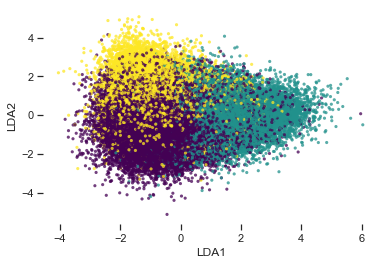

time: 25.7 s


In [23]:
lda = LinearDiscriminantAnalysis().fit(data, labels.valence)
dump(lda, f"{FEATURIZER_OUT_FOLDER}/LDA1_-_LDA2.joblib")
features = ["LDA1", "LDA2"]
data = pd.DataFrame(lda.transform(frill_data), columns=features)
data.index = labels.index
del lda
_ = gc_collect()
assert not data.isnull().values.any()
plot2d(data, labels, *features)
checkpoint_features(data, features)  # LDA1_-_LDA2.feather

In [24]:
bagged_gnb().fit(data, labels.valence).oob_score_

0.6852111033356659

time: 1.4 s


Improved!

# Local outlier factor of LDA components of FRILL embeddings

In [25]:
data, labels = load_data(filepath=f"{DATA_OUT_FOLDER}/LDA1_-_LDA2")
assert len(data) == len(labels)

time: 221 ms


['./feature_extractors/LDA-LOF_neg_20.joblib']

['./feature_extractors/LDA-LOF_neu_20.joblib']

['./feature_extractors/LDA-LOF_pos_20.joblib']

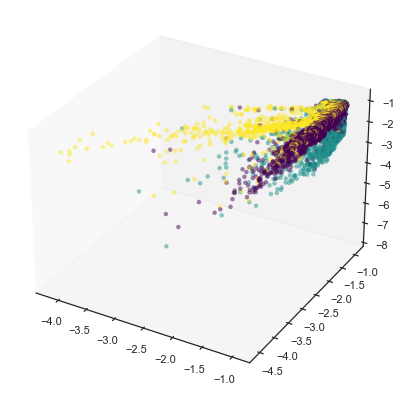

time: 2.99 s


In [26]:
n_neighbors = 20
for emo in ("neg", "neu", "pos"):
    valence = VALENCE[emo]
    key = f"LDA-LOF_{emo}_{n_neighbors}"
    data[key] = np.nan
    lof = LocalOutlierFactor(n_neighbors, novelty=True, n_jobs=-1).fit(
        data.loc[labels.valence == valence, ["LDA1", "LDA2"]].values
    )
    data.loc[labels.valence == valence, key] = lof.negative_outlier_factor_
    data.loc[labels.valence != valence, key] = lof.score_samples(
        data.loc[labels.valence != valence, ["LDA1", "LDA2"]].values
    )
    dump(lof, f"{FEATURIZER_OUT_FOLDER}/{key}.joblib")
    del valence
    del key
    del lof
    _ = gc_collect()
features = [
    f"LDA-LOF_neg_{n_neighbors}",
    f"LDA-LOF_neu_{n_neighbors}",
    f"LDA-LOF_pos_{n_neighbors}",
]
plot3d(data, labels, *features)
checkpoint_features(data, features)
del features
_ = gc_collect()

# One-class SVM scores of the LDA components of the FRILL embeddings

In [27]:
def extract_ocsvm_features(
    df: pd.DataFrame, labels: pd.DataFrame, model_base: Callable, descriptor: str
) -> pd.DataFrame:
    """Extract features using the given one-class SVM base"""
    prefix = f"ocSVM_{descriptor}"
    assert all(df.index == labels.index)

    # one-class scores of LDA components of FRILL embeddings
    print("extracting one-class scores of LDA components of FRILL embeddings...")
    for valence in VALENCE.keys():
        classifier = model_base().fit(
            df.loc[labels.valence == VALENCE[valence], ["LDA1", "LDA2"]]
        )
        feature = f"LDA-{prefix}_{valence}"
        df[feature] = classifier.score_samples(df.loc[:, ["LDA1", "LDA2"]])
        dump(classifier, f"{FEATURIZER_OUT_FOLDER}/{feature}.joblib")
        del classifier
        del feature
        _ = gc_collect()
    assert all(df.index == labels.index)
    features = [f"LDA-{prefix}_neg", f"LDA-{prefix}_neu", f"LDA-{prefix}_pos"]
    plot3d(df, labels, *features)
    checkpoint_features(df, features)

    return df


_ = gc_collect()

time: 118 ms


In [28]:
data, labels = load_data(filepath=f"{DATA_OUT_FOLDER}/LDA1_-_LDA2")
assert len(data) == len(labels)
assert all(data.index == labels.index)

time: 179 ms


In [29]:
oc_svms = {
    "sgdlinear": lambda: SGDOneClassSVM(random_state=SEED),
    "rbf": lambda: OneClassSVM(kernel="rbf"),
}
_ = gc_collect()

time: 134 ms


  0%|          | 0/2 [00:00<?, ?it/s]

extracting one-class scores of LDA components of FRILL embeddings...


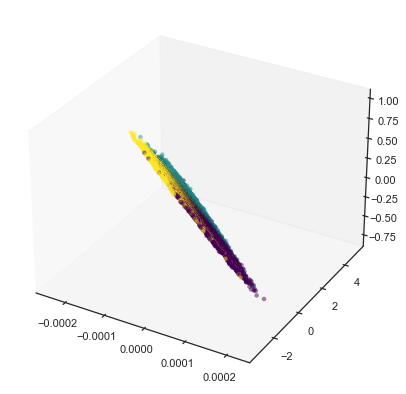

extracting one-class scores of LDA components of FRILL embeddings...


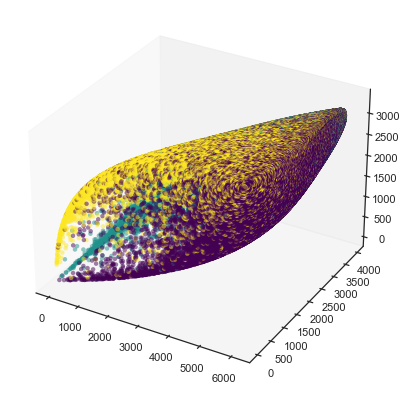

time: 11min 31s


In [30]:
for oc_svm, model_base in tqdm(oc_svms.items()):
    data = extract_ocsvm_features(data, labels, model_base, oc_svm)

# SGDOneClassSVM scores of FRILL embeddings

['./feature_extractors/ocSVM_sgdlinear_neg.joblib']

['./feature_extractors/ocSVM_sgdlinear_neu.joblib']

['./feature_extractors/ocSVM_sgdlinear_pos.joblib']

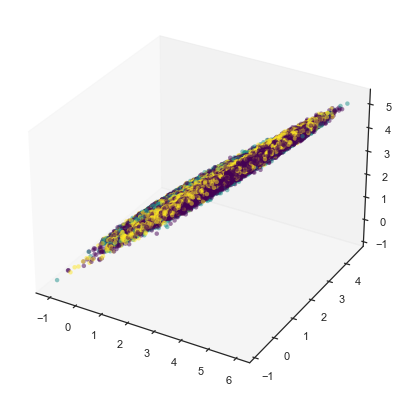

time: 6.46 s


In [31]:
prefix = f"ocSVM_sgdlinear"
df = {}
assert len(frill_data.columns) == 1024
for valence in VALENCE.keys():
    classifier = SGDOneClassSVM(random_state=SEED).fit(
        frill_data.loc[labels.valence == VALENCE[valence], :]
    )
    feature = f"{prefix}_{valence}"
    df[feature] = classifier.score_samples(frill_data)
    dump(classifier, f"{FEATURIZER_OUT_FOLDER}/{feature}.joblib")
    del classifier
    _ = gc_collect()
features = [f"{prefix}_neg", f"{prefix}_neu", f"{prefix}_pos"]
df = pd.DataFrame(df, columns=features)
df.index = labels.index
plot3d(df, labels, *features)
checkpoint_features(df, features)

In [32]:
prefix = "ocSVM_sgdlinear"
features = [f"{prefix}_neg", f"{prefix}_neu", f"{prefix}_pos"]

time: 1 ms


# Aggregate and scale

In [33]:
features_ = [
    # derived directly from FRILL embeddings
    ["LDA1", "LDA2"],
    ["ocSVM_sgdlinear_neg", "ocSVM_sgdlinear_neu", "ocSVM_sgdlinear_pos"],
    # derived from LDA1 and LDA2
    ["LDA-LOF_neg_20", "LDA-LOF_neu_20", "LDA-LOF_pos_20"],
    ["LDA-ocSVM_rbf_neg", "LDA-ocSVM_rbf_neu", "LDA-ocSVM_rbf_pos"],
    ["LDA-ocSVM_sgdlinear_neg", "LDA-ocSVM_sgdlinear_neu", "LDA-ocSVM_sgdlinear_pos"],
]

_ = gc_collect()

time: 135 ms


In [34]:
data = pd.concat(
    [
        pd.read_feather(f"{DATA_OUT_FOLDER}/{fname}.feather").set_index("id")
        for fname in ["_-_".join(features) for features in features_]
    ],
    axis="columns",
)
labels = load_labels().loc[data.index]
assert not data.isnull().values.any()
assert len(data) < 86000

time: 166 ms


In [35]:
bagged_gnb().fit(data, labels.valence).oob_score_

0.6714718917658036

time: 7 s


In [36]:
bagged_gnb().fit(RobustScaler().fit_transform(data), labels.valence).oob_score_

0.6796827618381153

time: 2.72 s


In [37]:
bagged_gnb().fit(
    RobustScaler(unit_variance=True).fit_transform(data), labels.valence
).oob_score_

0.6796827618381153

time: 2.65 s


In [38]:
BaggingClassifier(
    base_estimator=RidgeClassifierCV(scoring="balanced_accuracy"),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
).fit(RobustScaler().fit_transform(data), labels.valence).oob_score_

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.4s remaining:   10.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.4s finished


0.6816188476790296

time: 8.07 s


In [39]:
BaggingClassifier(
    base_estimator=RidgeClassifierCV(scoring="balanced_accuracy"),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
).fit(RobustScaler(unit_variance=True).fit_transform(data), labels.valence).oob_score_

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.1s remaining:    9.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.4s finished


0.6816421740144624

time: 7.57 s


In [40]:
dump(
    RobustScaler(unit_variance=True).fit(data),
    f"{FEATURIZER_OUT_FOLDER}/robust_scaler.joblib",
)

['./feature_extractors/robust_scaler.joblib']

time: 48.9 ms


In [41]:
cols = data.columns
data = pd.DataFrame(RobustScaler(unit_variance=True).fit_transform(data), columns=cols)
data.columns = data.columns.astype(str)
assert len(labels.index) < 86000
data.index = labels.index
data.reset_index().to_feather(
    f"{DATA_OUT_FOLDER}/scaled_features_ready_for_selection.feather"
)
del cols
_ = gc_collect()

time: 217 ms


# Spot check

In [42]:
data = pd.read_feather(
    f"{DATA_OUT_FOLDER}/scaled_features_ready_for_selection.feather"
).set_index("id")
labels = load_labels().loc[data.index]
assert len(data) == len(labels)
assert not data.isnull().values.any()
assert all(data.index == labels.index)

time: 144 ms


In [43]:
bagged_gnb().fit(data, labels.valence).oob_score_

0.6796827618381153

time: 2.72 s


# Discussion

Looks like the simplified feature set isn't so bad.

In [44]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 1737.1506750583649 s
time: 138 ms


[^top](#Contents)